In [1]:
import time
tstart = time.time()

In [2]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import h5py
import hdf5plugin  # REQUIRED to have the compression plugins available
import numpy as np
import pandas as pd
import re
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
import copy
import warnings
from astropy import units
from scipy import constants, interpolate, special
from scipy.signal.windows import dpss
from pyuvdata import UVBeam
from pyuvdata import utils as uvutils
from hera_cal import io, utils, vis_clean, frf, datacontainer, noise, redcal
from hera_qm.time_series_metrics import true_stretches
from hera_filters import dspec
import hera_pspec as hp
import uvtools
from IPython.display import HTML
from pathlib import Path
import sys

In [3]:
TAPER = "bh"
EFIELD_HEALPIX_BEAM_FILE = (
    "/lustre/aoc/projects/hera/H4C/beams/NF_HERA_Vivaldi_efield_beam_healpix.fits"
)
EFIELD_HEALPIX_BEAM_FILE = Path(EFIELD_HEALPIX_BEAM_FILE)
CORR_MATRIX_NOTCH_CUTOFF = 30.0
CORR_MATRIX_FREQ_DECIMATION = 10
USE_CORR_MATRIX = True
TARGET_AVERAGING_TIME = 300
FR_EIGENVAL_CUTOFF = 1e-12
FR_QUANTILE_HIGH = 0.95
FR_QUANTILE_LOW = 0.05
FR_SPECTRA_FILE = "/lustre/aoc/projects/hera/zmartino/hera_frf/spectra_cache/spectra_cache_hera_core.h5"
FR_SPECTRA_FILE = Path(FR_SPECTRA_FILE)
XTALK_FR = 0.01
NINTERLEAVE = 4
INTEGRATION_FLAG_CUT = 0.2
CHANNEL_FLAG_CUT = 0.0
PIXEL_FLAG_CUT = 0.0
FM_CUT_FREQ = 100000000.0
FLAG_COHERENT_CHUNKS = False
USE_BAND_AVG_NSAMPLES = True
BAND_STR = "50.1~62.2,63.3~73.5,74.6~85.4,108.0~116.1,117.3~124.4,125.3~136.2,138.3~148.2,150.1~159.2,159.3~169.9,171.9~181.1,181.4~196.4,198.5~208.4,212.3~220.6,224.4~231.1"


In [10]:
import hera_pspec as hp
import numpy as np
from scipy import special, integrate
import uvtools.dspec as dspec
from hera_pspec import uvwindow, conversions
from astropy import constants
import copy

class simple_pspec:
    def __init__(self, vis1, vis2, nsample1, nsample2, 
                 freqs, beamfunc, beamtype="healpix",
                 cosmo=None, little_h=True,
                 vis_unit='mK', taper='blackman-harris'):
        self.spw_Nfreqs = freqs.size
        self.spw_Ndlys  = freqs.size
        self.x1 = copy.deepcopy(vis1)
        self.x2 = copy.deepcopy(vis2)
        self.w1 = nsample1
        self.w2 = nsample2
        self.freqs = freqs  
        df = np.median(np.diff(self.freqs))
        self.delays = np.fft.fftshift(np.fft.fftfreq(self.spw_Ndlys, d=df)) #in sec
        
        self.taper = taper
        self.Q_alt = {}
        if self.taper == 'none':
            self.taper_func = np.ones(self.spw_Nfreqs)
        else:
            self.taper_func = dspec.gen_window(self.taper, self.spw_Nfreqs)
            
        if beamtype == "healpix":
            raise NotImplementedError
            
        elif beamtype == "pspec_beam":
            if type(beamfunc) == hp.pspecbeam.PSpecBeamUV:
                _beam, beam_omega, N = \
                beamfunc.beam_normalized_response(pol='pI', freq=self.freqs)
            elif type(beamfunc) == tuple:
                assert len(beamfunc) == 3, "Invalid beam function"
                _beam, beam_omega, N = beamfunc
            else:
                raise ValueError("Invalid beam function")
            
            self.omega_p = beam_omega.real
            self.omega_pp = np.sum(_beam**2, axis=-1).real*np.pi/(3.*N*N)
            _beam = _beam/self.omega_p[:, None]
            
            self.qnorm_exact = np.pi/(3.*N*N) * np.dot(_beam, _beam.T)
            self.qnorm_exact *= np.median(np.diff(self.delays))
            
        elif beamtype == "azimuthal":
            _th = np.linspace(0, np.pi/2, 500) #Only above the ground
            _beam = beamfunc(_th, self.freqs)
            self.omega_p = 2*np.pi*integrate.simpson(_beam*np.sin(_th), x=_th, axis=-1)
            self.omega_pp = 2*np.pi*integrate.simpson(_beam**2*np.sin(_th), x=_th, axis=-1)

            _beam = _beam/self.omega_p[:, None]
            self.qnorm_exact = 2*np.pi*integrate.simpson(_beam[:, None, :]*_beam[None, :, :]*np.sin(_th), x=_th, axis=-1)
            self.qnorm_exact *= np.median(np.diff(self.delays))
        
        else:
            raise NotImplementedError

        if cosmo is not None:
            self.cosmo = cosmo
        else:
            self.cosmo = conversions.Cosmo_Conversions()
        df = np.median(np.diff(self.freqs))
        integration_freqs = np.linspace(self.freqs.min(),
                                        self.freqs.min() + df*self.spw_Nfreqs,
                                        5000, endpoint=True, dtype=float)
        integration_freqs_MHz = integration_freqs / 1e6

        # Get redshifts and cosmological functions
        redshifts = self.cosmo.f2z(integration_freqs).flatten()
        X2Y = np.array([self.cosmo.X2Y(z, little_h=little_h) for z in redshifts])
        self.scalar = integrate.trapezoid(X2Y, x=integration_freqs)/(np.abs(integration_freqs[-1]-integration_freqs[0]))
        
        if vis_unit == 'Jy':
            c =  constants.c.cgs.value
            k_b =  constants.k_B.cgs.value
            self.Jy2mK = 1e3 * 1e-23 * c**2 / (2 * k_b * self.freqs**2 * self.omega_p)
            self.x1 *= self.Jy2mK
            self.x2 *= self.Jy2mK
        
    def get_R(self):
        return np.diag(self.taper_func)
        
    def get_Q_alt(self, mode):
        try:
            Q_alt = self.Q_alt[mode]
        except KeyError:
            if self.spw_Ndlys % 2 == 0:
                start_idx = -self.spw_Ndlys/2
            else:
                start_idx = -(self.spw_Ndlys - 1)/2
            m = (start_idx + mode) * np.arange(self.spw_Nfreqs)
            m = np.exp(-2j * np.pi * m / self.spw_Ndlys)
            Q_alt = np.einsum('i,j', m.conj(), m) # dot it with its conjugate
            self.Q_alt[mode] = Q_alt
            
        return Q_alt 
        
    def get_GH(self, operator=None):
        G = np.zeros((self.spw_Ndlys, self.spw_Ndlys), dtype=complex)
        H = np.zeros((self.spw_Ndlys, self.spw_Ndlys), dtype=complex)
        R = self.get_R()
        
        sinc_matrix = np.zeros((self.spw_Nfreqs, self.spw_Nfreqs))
        for i in range(self.spw_Nfreqs):
            for j in range(self.spw_Nfreqs):
                sinc_matrix[i,j] = float(i - j)
        sinc_matrix = np.sinc(sinc_matrix / float(self.spw_Nfreqs))
        
        iR1Q1, iR2Q2, iR1Q1_win, iR2Q2_win = {}, {}, {}, {}
        for ch in range(self.spw_Ndlys):
            Q_alt = self.get_Q_alt(ch)
            if operator is not None:
                iR1Q1[ch] = np.conj(operator).T@np.conj(R).T@(Q_alt) # O R_1 Q_alt
                iR2Q2[ch] = R@operator@(Q_alt* self.qnorm_exact) # R_2 OQ_true
                iR1Q1_win[ch] = iR1Q1[ch] #np.conj(operator).T@np.conj(R).T@(Q_alt) # O R_1 Q_alt
                iR2Q2_win[ch] = R@operator@(Q_alt* self.qnorm_exact * sinc_matrix) # R_2 O Q_true
            else:
                iR1Q1[ch] = np.conj(R).T@(Q_alt) # R_1 Q_alt
                iR2Q2[ch] = R@(Q_alt * self.qnorm_exact) # R_2 Q_true                
                iR1Q1_win[ch] = iR1Q1[ch] # R_1 Q_alt
                iR2Q2_win[ch] = R@(Q_alt* self.qnorm_exact * sinc_matrix) # R_2 Q_true
            
        for i in range(self.spw_Ndlys):
            for j in range(self.spw_Ndlys):
                # tr(R_2 Q_i R_1 Q_j)
                G[i,j] = np.einsum('ab,ba', iR1Q1[i], iR2Q2[j])  
                H[i,j] = np.einsum('ab,ba', iR1Q1_win[i], iR2Q2_win[j])
        if np.count_nonzero(G) == 0:
            G = np.eye(self.spw_Ndlys)
        if np.count_nonzero(H) == 0:
            H = np.eye(self.spw_Ndlys)            
        self.G = G/2.
        self.H = H/2.
        return G/2., H/2. 

    def get_MW(self, GH=None, operator=None):
        if GH is None:
            if hasattr(self, 'G'):
                G, H = self.G, self.H
            else:
                G, H = self.get_GH(operator)
        else:
            G, H = GH
        M = np.diag(1. / np.sum(G, axis=1)) 
        W_norm = np.diag(1. / np.sum(H, axis=1))
        W = np.dot(W_norm, H)
        return M, W
    
    def p_hat(self, calc_cov=False, Cnos1=None, Cnos2=None, SN=False, s_model=None):
        R = self.get_R()
        Rx1 = np.dot(R, self.x1.T)
        Rx2 = np.dot(R, self.x2.T)
        Q_alt_tensor = np.array([self.get_Q_alt(mode) for mode in range(self.spw_Ndlys)])
        QRx2 = np.dot(Q_alt_tensor, Rx2)
        q = 1/2*np.einsum('i...,ji...->j...', Rx1.conj(), QRx2)
        
        M, W = self.get_MW()
        M *= self.scalar
        p = M@q
        
        if calc_cov:
            if hasattr(self, 'E_matrices'):
                E_matrices = self.E_matrices
            else:
                E_matrices = 1/2*np.diag(np.conj(R).T)[None, :, None]*Q_alt_tensor*np.diag(R)[None, None, :]
                E_matrices = np.einsum('ab, bij->aij', M, E_matrices)
                self.E_matrices = E_matrices

            Cnos1 = Cnos1.astype(np.complex128)
            if Cnos2 is None:
                Cnos2 = Cnos1.astype(np.complex128)
            else:
                Cnos2 = Cnos2.astype(np.complex128)
            
            if hasattr(self, 'einstein_path'):
                einstein_path_0, einstein_path_1, einstein_path_2 = self.einstein_path
            else:
                einstein_path_0 =  np.einsum_path('bij, cji->bc', E_matrices, E_matrices, optimize='optimal')[0]
                einstein_path_1 = np.einsum_path('bi, cj,ij->bc', 
                                                 E_matrices[:,:,0], E_matrices[:,:,0], E_matrices[0,:,:], 
                                                 optimize='optimal')[0]
                einstein_path_2 =  np.einsum_path('ab,cd,bd->ac', M, M, M, optimize='optimal')[0]
                self.einstein_path = (einstein_path_0, einstein_path_1, einstein_path_2)
            
            if SN:
                raise NotImplementedError("P_SN currently not supported")
                '''
                if s_model is None:
                    Csig = 1/2*(self.x1[:, None]*self.x2[None, :].conj() + self.x2[:, None]*self.x1[None, :].conj())
                else:
                    Csig = s_model[:, None]*s_model[None, :].conj()
                E_Csn = np.einsum("aij, jk->aik", E_matrices, (Csig+Cnos))
                E_Csig = np.einsum("aij, jk->aik", E_matrices, Csig)
                p_pdagger = np.einsum('bij, cji->bc', E_Csn, E_Csn, optimize=einstein_path_0)
                p_pdagger -= np.einsum('bij, cji->bc', E_Csig, E_Csig, optimize=einstein_path_0)
                '''
            else:
                E_Cnos1 = np.einsum("aij, jk->aik", E_matrices, Cnos1)
                E_Cnos2 = np.einsum("aij, jk->aik", E_matrices, Cnos2)
                p_pdagger = 1/2*np.einsum('bij, cji->bc', E_Cnos1, E_Cnos2, optimize=einstein_path_0)
            '''
            if SN:
                if s1 is None:
                    s1 = self.x1
                if s2 is None:
                    s2 = self.x2                   
                E12_x1 = np.dot(E_matrices, s1)
                E12_x2 = np.dot(E_matrices, s2)
                x2star_E21 = E12_x2.conj()
                x1star_E21 = E12_x1.conj()
                x1star_E12 = np.dot(np.transpose(E_matrices,(0,2,1)), s1.conj())
                x2star_E12 = np.dot(np.transpose(E_matrices,(0,2,1)), s2.conj())
                E21_x1 = x1star_E12.conj()
                E21_x2 = x2star_E12.conj()
                SN_cov = (np.einsum('bi,cj,ij->bc', E12_x1, x2star_E21, C11, optimize=einstein_path_1)/2. + 
                          np.einsum('bi,cj,ij->bc', E12_x2, x1star_E21, C11, optimize=einstein_path_1)/2. +
                          np.einsum('bi,cj,ij->bc', x2star_E12, E21_x1, C22, optimize=einstein_path_1)/2. + 
                          np.einsum('bi,cj,ij->bc', x1star_E12, E21_x2, C22, optimize=einstein_path_1)/2.
                         )
                # Apply zero clipping on the columns and rows containing negative diagonal elements
                SN_cov[np.real(np.diag(SN_cov))<=0., :] = 0. + 1.j*0
                SN_cov[:, np.real(np.diag(SN_cov))<=0.,] = 0. + 1.j*0
                q_qdagger += SN_cov  
            '''
            return p, p_pdagger
            
        else:
            return p
                
def airy_beam(theta, freqs, a=6):
    
    k = 2*np.pi * freqs / constants.c.value
    k = k[:, np.newaxis]

    arg = k*6*np.sin(theta)

    beam = (2*special.jv(1,arg)/arg)**2
    beam = np.where(np.isnan(beam), 1, beam)

    return beam



In [4]:
def parse_band_str(band_str: str, freqs: np.ndarray) -> tuple[float, list[float], list[float], list[float], list[slice], list[int]]:
    """Parse a band string into a channel width and a list of slices.
    
    Parameters
    ----------
    band_str : str
        A string of comma-separated frequency bands in the form 'low~high'.
    freqs : np.ndarray
        An array of frequencies in Hz.
        
    Returns
    -------
    df
        The channel width in Hz.
    bands
        A list of the frequency bands in the form (low, high) ub Hz
    min_freqs
        A list of the minimum frequencies in the bands in MHz.
    max_freqs
        A list of the maximum frequencies in the bands in MHz.
    band_slices
        A list of slices corresponding to the bands.
    nchans
        A list of the number of channels in each band.
    """
    df = np.median(np.diff(freqs))
    bands = [tuple([float(edge) for edge in band.split('~')]) for band in band_str.strip().split(',')]
    min_freqs = [(np.min(freqs[freqs >= (1e6 * b[0])]) - df / 2) / 1e6 for b in bands]
    max_freqs = [(np.max(freqs[freqs <= (1e6 * b[1])]) + df / 2) / 1e6 for b in bands]
    min_chan = [np.where(freqs >= 1e6 * b[0])[0][0] for b in bands]
    max_chan = [np.where(freqs <= 1e6 * b[1])[0][-1] for b in bands]
    band_slices = [slice(minc, maxc+1) for minc, maxc in zip(min_chan, max_chan)]
    nchans = [maxc - minc + 1 for minc, maxc in zip(min_chan, max_chan)]
    
    return (
        df,
        bands,
        min_freqs, 
        max_freqs, 
        band_slices,
        nchans,
    )

In [6]:
# Chose an ANTPAIR
ANTPAIR = (99, 22)

In [13]:
SINGLE_BL_FOLDER = Path("/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/")
SINGLE_BL_UVH5 = SINGLE_BL_FOLDER / f"zen.LST.baseline.{ANTPAIR[0]}_{ANTPAIR[1]}.sum.uvh5"
SINGLE_BL_PSPEC = SINGLE_BL_FOLDER / f"zen.LST.baseline.{ANTPAIR[0]}_{ANTPAIR[1]}.sum.tavg.pspec.h5"

In [8]:
if not SINGLE_BL_FILE.is_file():
    raise ValueError(f"Invalid baseline ({ANTPAIR[0]}, {ANTPAIR[1]})")

all_files = SINGLE_BL_FILE.parent.glob(SINGLE_BL_FILE.name.replace(f'{ANTPAIR[0]}_{ANTPAIR[1]}', '*'))
AUTO_BL_FILE = sorted([f for f in all_files if len(set(re.search(r'\d+_\d+', f.name).group().split('_'))) == 1])[0]
single_bl_times = np.array(io.HERAData(SINGLE_BL_FILE).times)
hd = io.HERAData([AUTO_BL_FILE, SINGLE_BL_FILE])
data, flags, nsamples = hd.read(times=single_bl_times)
cross_bls = [ANTPAIR + (pol,) for pol in data.pols()]

In [14]:
psc = hp.container.PSpecContainer(SINGLE_BL_PSPEC, mode='r', keep_open=False)
uvp = psc.get_pspec('stokespol', 'time_and_interleave_averaged')

In [15]:
# Derive pspec and cov with simple_ps
beam_hera = hp.PSpecBeamUV("/lustre/aoc/projects/hera/H4C/beams/NF_HERA_Vivaldi_efield_beam_healpix_pstokes.fits")
pre_calc_beam = []
for spw in uvp.spw_array:
    beam_tuple = beam_hera.beam_normalized_response(pol='pI', freq=uvp.freq_array[uvp.spw_freq_array ==spw])
    pre_calc_beam.append(beam_tuple)

In [34]:
%%time
# Now let's compare full covariance calculation vs hacky way by scaling a template with P_N
# Calculate a PS covariance assuming identity visibility space nosie matrix
hdf = hd.freqs[Path('/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-inpaint-500ns-lstcal/inpaint/single_baseline_files/zen.LST.baseline.99_22.sum.uvh5')]
df = np.median(np.diff(hdf))
dt = np.median(hd.integration_time)

# simple_ps_interleave = {}
# simple_ps_cov_interleave = {}
Tsys_template = np.nanmean(hd.get_data((0, 0, 'ee')).real+hd.get_data((0, 0, 'nn')).real, axis=0)/np.sqrt(df*dt)
PS_cov_template = {}
for spw in uvp.spw_array:
    # simple_ps_interleave[spw] = []
    # simple_ps_cov_interleave[spw] = []
    freqs = uvp.freq_array[uvp.spw_freq_array == spw]
    ps_obj = simple_pspec(
        np.zeros(freqs.size), 
        np.zeros(freqs.size), 
        None, None, 
        freqs=freqs,
        beamfunc=pre_calc_beam[spw], beamtype="pspec_beam",
        cosmo=None, little_h=True,
        vis_unit='Jy', taper='blackman-harris'
    )  

    hdmask = np.isin(hdf, freqs, assume_unique=True)
    Cnos1 = np.diag(Tsys_template[hdmask]**2*np.ones(freqs.size))
    Cnos2 = np.diag(Tsys_template[hdmask]**2*np.ones(freqs.size))
    _, _ps_cov_template = ps_obj.p_hat(calc_cov=True, Cnos1=Cnos1, Cnos2=Cnos2)
    PS_cov_template[spw] = _ps_cov_template.real/np.diag(_ps_cov_template.real)

#np.save("/lustre/aoc/projects/hera/kfchen/H6C/inpainting/Noise_Sim.ipynbPS_Cov_Template.npy", PS_cov_template)

In [69]:
# Also get it an ever dumber way
from scipy.signal.windows import blackmanharris

n = 89
taper = blackmanharris(89)
cov = np.abs(np.fft.fft(taper**2))**2

(1e-08, 2)

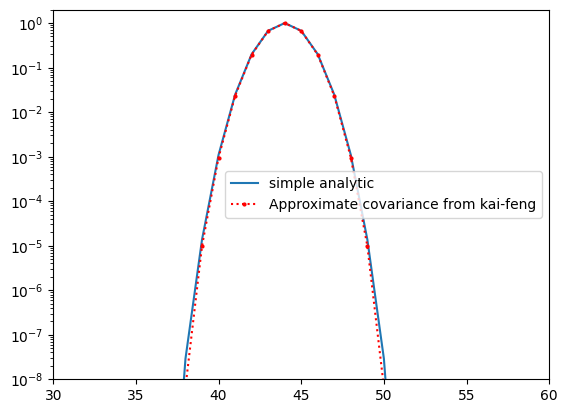

In [79]:
plt.plot(np.fft.fftshift(cov)/cov.max(), label='simple analytic')


cen_idx = np.searchsorted(delays, 0)
plt.plot(cov_guess[cen_idx, :]/cov_guess[cen_idx].max(), 'ro:', ms=2, label="Approximate covariance from kai-feng")

plt.yscale('log')
plt.legend()
plt.xlim(30, 60)
plt.ylim(1e-8, 2)

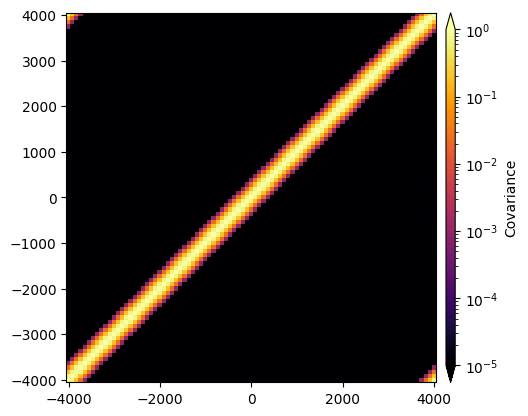

In [68]:
spw = 2
key = uvp.get_all_keys()[0]
delays = uvp.get_dlys(spw) * 1e9
cov_guess = PS_cov_template[spw]
im = plt.imshow(
    cov_guess.real, interpolation=None, origin="lower", aspect="equal",
    #norm=matplotlib.colors.LogNorm(vmin=(pn.real**2).min(), vmax=(pn.real**2).max()),
    norm=matplotlib.colors.LogNorm(vmin=cov_guess.real.max()/1e5, vmax=cov_guess.real.max()),
    cmap="inferno", extent=[delays.min(), delays.max(), delays.min(), delays.max()]
)


plt.colorbar(im, pad=.02, aspect=40, extend='both', label='Covariance')
plt.show()